## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import sinogap_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 3
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 64    #16384 #32768
    ,batchSplit = 1
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.000005
    ,learningRateG = 0.000005
)

sg.DCfg = sg.DCfgClass(16)

#torch.cuda.memory._record_memory_history(device=sg.TCfg.device)
#torch.cuda.memory._dump_snapshot("/data/anton/sinogap/cudaOOM.pickle")
#torch.cuda.memory._record_memory_history(enabled=None)


### <font style="color:lightblue">Raw Read</font>

In [ ]:
trainSet = sg.createTrainSet()
prepGdLoss=0
testSet = sg.createTestSet()

Loaded set 19736b.09_Feb.4176862R_Eig_Threshold-4keV


### <font style="color:lightblue">Show</font>

In [ ]:
print(len(trainSet))
sg.refImages, sg.refNoises = sg.createReferences(trainSet, 0)
sg.showMe(trainSet, 0 )

## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">Generator</font>

In [ ]:


class Generator16(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator16, self).__init__(16,1)

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (1+self.latentChannels)/self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, dopadding=True),
            self.decblock(32,  8, 4, stride=2),
            self.decblock(16,  8, 3, dopadding=True),
            self.decblock(16,  4, 4, stride=2),
            self.decblock( 8,  4, 3, dopadding=True),
            self.decblock( 8,  2, 4, stride=2),
            self.decblock( 4,  2, 3, dopadding=True),
            self.decblock( 4,  1, 4, stride=2),
            self.decblock( 2,  1, 3, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()


sg.generator = Generator16()
sg.generator.to(sg.TCfg.device)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)

sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)





### <font style="color:lightblue">Discriminator</font>

In [ ]:


class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__(0)
        self.body =  nn.Sequential(
            self.encblock( 1/self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            )
        self.head = self.createHead()




sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



## <font style="color:lightblue">Restore checkpoint</font>

Probabilities of reference images: Ref: 9.936e-01, Gen: 4.359e-01, Pre: 2.713e-03.
Distances of reference images: REC: 1.998e-01, MSE: 1.998e-01, L1L: 4.386e-01.


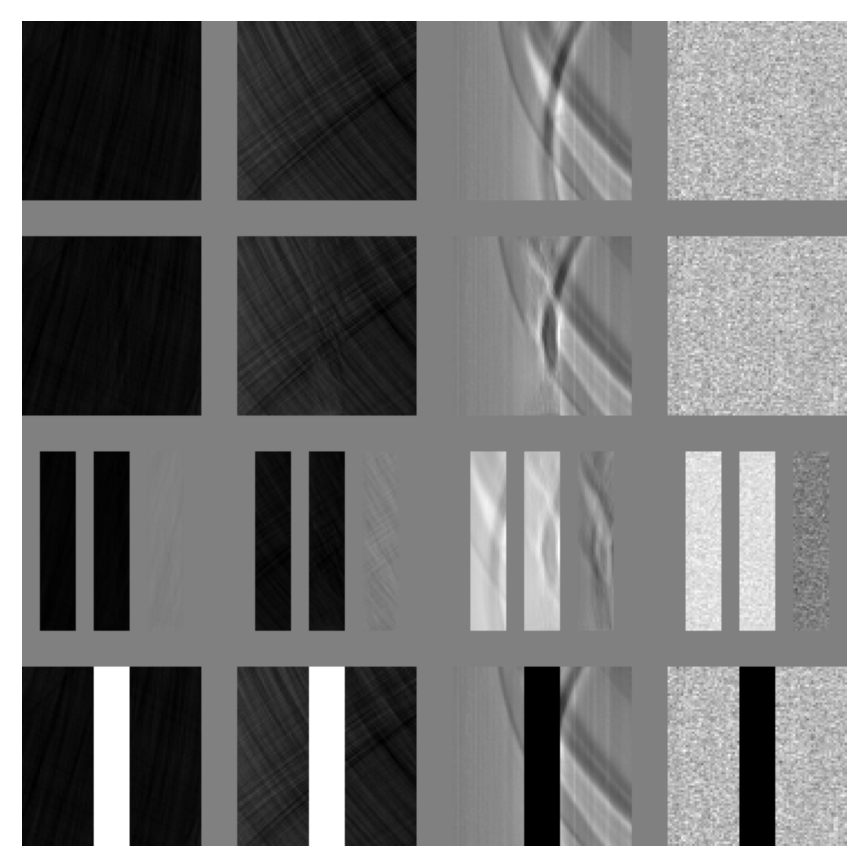

In [10]:
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.iter, sg.minGEpoch, sg.minGdLoss, sg.startFrom = \
    sg.restoreCheckpoint(savedCheckPoint+"_hourly.pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG/4)
#sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD/4)
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

## <font style="color:lightblue">Execute</font>

Epoch: 8 (3).  Dis[0.51]: 0.397 (0.963), Gen[1.00]: 1.912 (0.008), Rec: 2.591e-03 (2.591e-03 / 2.711e-03).
TT: 0.92 (2822751,507),  FT: 0.27 (1767528,1268),  HD: 2.691e-02 (3931710,42),  GP: 0.077, 0.918 
TF: 0.61 (1287937,1062),  FF: 0.03 (1316289,1357),  LD: 2.191e-05 (1607400,868),  R : 0.063.


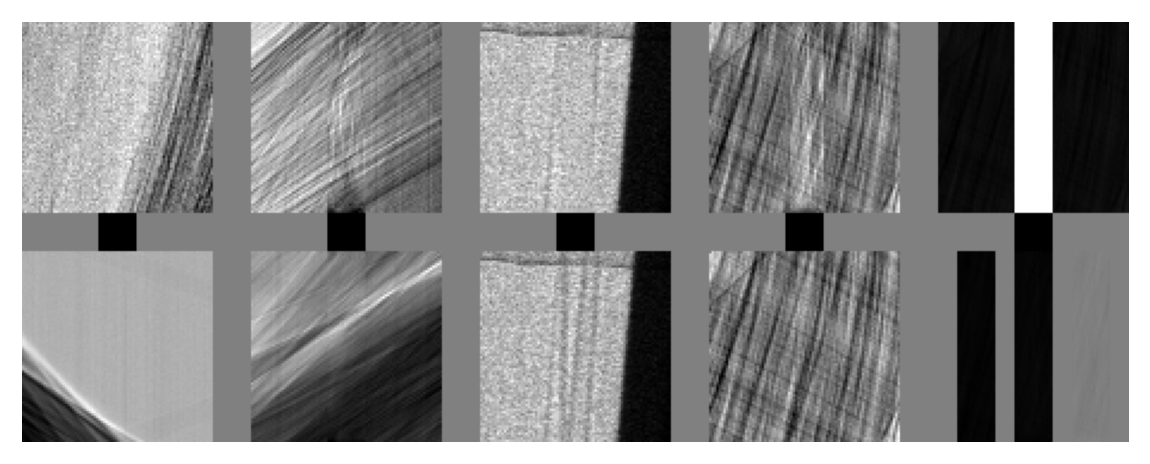

  9%|▉         | 8192/90860 [01:00<6:07:41,  3.75it/s]

In [ ]:
sg.scheduler_G = sg.createScheduler(sg.optimizer_G)
sg.scheduler_D = sg.createScheduler(sg.optimizer_D)

#torch.autograd.set_detect_anomaly(True)
#sg.TCfg.batchSize = 64
sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=8)
sg.testLoader = sg.createTestLoader(testSet, num_workers=8)
#Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.testLoader)
##Summary. Rec: 2.203e-03, MSE: 2.203e-03, L1L: 1.882e-02.
#sg.writer.add_scalars("Test per epoch",
#                   {'MSE': MSE_diff
#                   ,'L1L': L1L_diff
#                   ,'REC': Rec_diff
#                   }, 0 )
#Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.testLoader, False)
##Summary. Rec: 2.190e-03, MSE: 2.190e-03, L1L: 1.854e-02
#sg.writer.add_scalars("Test per epoch",
#                   {'MSE': MSE_diff
#                   ,'L1L': L1L_diff
#                   ,'REC': Rec_diff
#                   }, sg.epoch )

#torch.autograd.set_detect_anomaly(True)
#Summary. Rec: 2.711e-03, MSE: 2.711e-03, L1L: 3.165e-02.
Rec_diff, MSE_diff, L1L_diff = 2.711e-03, 2.711e-03, 3.165e-02
sg.prepGdLoss =  Rec_diff
if Rec_diff == 0:
    Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.dataLoader)
if not sg.epoch :
    sg.writer.add_scalars("Distances per epoch",
                          {'MSE': MSE_diff
                          ,'L1L': L1L_diff
                          ,'REC': Rec_diff
                          }, 0 )

sg.lossDifCoef = 128
sg.noAdv = False
sg.lossAdvCoef = 1.0

#def my_beforeReport() :
#    sg.lossDifCoef = min(1024, sg.lossDifCoef * 1.001)
#    print(f"Loss coefficient: {sg.lossDifCoef}")
#    with open(f"inrun_{sg.TCfg.exec}.txt", 'a') as file:
#        file.write(f"Epoch {sg.epoch}, Iter {sg.iter}, lossDifCoef: {sg.lossDifCoef}.\n")
#sg.beforeReport = my_beforeReport

try :
    sg.train(savedCheckPoint)
except :
    sg.epoch -= 1
    del sg.dataLoader
    del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    raise


 # adv, no preProc

## <font style="color:lightblue">Post</font>

In [ ]:
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()